In [1]:
import json
import os
import time

import matplotlib.pylab as plt
import numpy as np
import tqdm

In [3]:
RANDOM_MODEL_DIR = "/mnt/data/john/nas_similarity_experiments/random_genotype/"
BEST_MODEL_DIR = "/mnt/data/john/nas_similarity_experiments/best_genotype/"
LOG = "log.txt"
PREDICTIONS = "predictions_{}.npy"

In [128]:
def get_models(model_dir):
    names = os.listdir(model_dir)
    
    num_1 = 0
    num_200 = 0 
    num_600 = 0
    num_700 = 0
    for name in names:
        num_1 += os.path.isfile(os.path.join(model_dir, name, PREDICTIONS.format(0))) 
        num_200 += os.path.isfile(os.path.join(model_dir, name, PREDICTIONS.format(200)))
        num_600 += os.path.isfile(os.path.join(model_dir, name, PREDICTIONS.format(599)))
        num_700 += os.path.isfile(os.path.join(model_dir, name, PREDICTIONS.format(700)))

    print(f"{num_1} models in {model_dir} have trained for 1 epochs")
    print(f"{num_200} models in {model_dir} have trained for 200 epochs")
    print(f"{num_600} models in {model_dir} have trained for 600 epochs")
    print(f"{num_700} models in {model_dir} have trained for 700 epochs")
    print()
    return [os.path.join(model_dir, name) for name in names]

random_model_names = get_models(RANDOM_MODEL_DIR)
best_model_names = get_models(BEST_MODEL_DIR)

11 models in /mnt/data/john/nas_similarity_experiments/random_genotype/ have trained for 1 epochs
11 models in /mnt/data/john/nas_similarity_experiments/random_genotype/ have trained for 200 epochs
8 models in /mnt/data/john/nas_similarity_experiments/random_genotype/ have trained for 600 epochs
0 models in /mnt/data/john/nas_similarity_experiments/random_genotype/ have trained for 700 epochs

12 models in /mnt/data/john/nas_similarity_experiments/best_genotype/ have trained for 1 epochs
10 models in /mnt/data/john/nas_similarity_experiments/best_genotype/ have trained for 200 epochs
8 models in /mnt/data/john/nas_similarity_experiments/best_genotype/ have trained for 600 epochs
0 models in /mnt/data/john/nas_similarity_experiments/best_genotype/ have trained for 700 epochs



How good are the models we're training?

In [14]:
answers = np.load("testvecs.npy")

In [94]:
def load_prediction(fname):
    """Annoying loading because I'm dumb and saved top-5 predictions for each point, not top-1"""
    preds = np.load(fname)
    full_batches = preds[:-80]
    last_batch = preds[-80:]
    full_batch_preds = np.hstack([batch[:96] for batch in np.split(full_batches, 104)])
    last_batch_preds = last_batch[:16]
    return np.append(full_batch_preds, last_batch_preds)

In [98]:
def best_test(name):
    final_preds = os.path.join(name, PREDICTIONS.format(599))
    if os.path.isfile(final_preds):
        preds = load_prediction(final_preds)
        return np.mean(preds == answers)
    return None

[0.9733, 0.9687, 0.9689, 0.9665, 0.9666, 0.9633, 0.9706, 0.967]
Using 8  models...


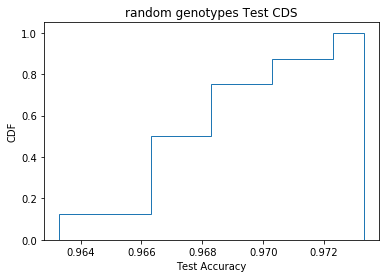

[0.9655, 0.9638, 0.9693, 0.9707, 0.9709, 0.9661, 0.9723, 0.9701]
Using 8  models...


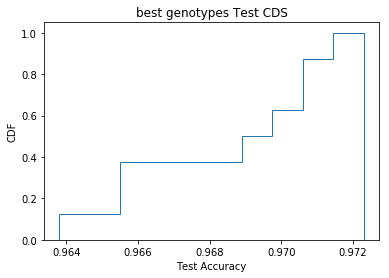

In [100]:
def plot_test_cdf(model_names, label):
    test_accs = [best_test(name) for name in model_names]
    test_accs = [x for x in test_accs if x is not None]
    print(test_accs)
    print(f"Using {len(test_accs)}  models...")
    plt.hist(test_accs, cumulative=True, label='CDF', density=True, histtype='step')
    plt.xlabel("Test Accuracy")
    plt.ylabel("CDF")
    plt.title(f"{label} Test CDS")
    plt.show()
    
plot_test_cdf(random_model_names, "random genotypes")
plot_test_cdf(best_model_names, "best genotypes")

Estimate average similarity for random models and best models using final checkpoint

In [143]:
random_model_preds  = []
for name in random_model_names:
    fname = os.path.join(name, PREDICTIONS.format(599))
    if not os.path.isfile(fname):
        continue
    random_model_preds.append(load_prediction(fname))

accs = [np.mean(pred == answers) for pred in random_model_preds]

sims = []
for idx, pred1 in enumerate(random_model_preds):
    for pred2 in random_model_preds[idx+1:]:
        sims.append(np.mean((pred1 == answers) == (pred2 == answers)))

print("Random NAS Configs")
print(f"Using {len(accs) + 1} models")
print(f"Average pairwise similarity {np.mean(sims)}")
print(f"Average accuracy {np.mean(accs)}")
print(np.min(sims), np.max(sims))
print(np.max(accs))
print(accs)

w = 1.96 * (np.std(sims) / np.sqrt(len(sims)))
print(np.mean(sims) - w, np.mean(sims) + w)

Random NAS Configs
Using 9 models
Average pairwise similarity 0.9761035714285714
Average accuracy 0.9681124999999999
0.9728 0.9799
0.9733
[0.9733, 0.9687, 0.9689, 0.9665, 0.9666, 0.9633, 0.9706, 0.967]
0.9753496170201355 0.9768575258370074


In [141]:
random_model_preds  = []
for name in best_model_names:
    fname = os.path.join(name, PREDICTIONS.format(599))
    if not os.path.isfile(fname):
        continue
    random_model_preds.append(load_prediction(fname))

accs = [np.mean(pred == answers) for pred in random_model_preds]

sims = []
for idx, pred1 in enumerate(random_model_preds):
    for pred2 in random_model_preds[idx+1:]:
        sims.append(np.mean((pred1 == answers) == (pred2 == answers)))

print("Top-50 NAS Configs")
print(f"Using {len(accs)} models")
print(f"Average pairwise similarity {np.mean(sims)}")
print(f"Average accuracy {np.mean(accs)}")
print(np.min(sims), np.max(sims))
print(np.max(accs))
print(accs)

1.96 * (np.std(sims) / np.sqrt(len(sims)))

Top-50 NAS Configs
Using 8 models
Average pairwise similarity 0.975975
Average accuracy 0.9685874999999999
0.973 0.9798
0.9723
[0.9655, 0.9638, 0.9693, 0.9707, 0.9709, 0.9661, 0.9723, 0.9701]


0.000724127923781427

In [135]:
np.max(accs)

0.9733

Compute similarities for all of the models

In [101]:
# Models all trained for 200 epochs. Take 10 checkpoints during training
checkpoints = list(range(0, 600, 50)) + [599]

predictions = []
for name in random_model_names:
    for checkpoint in checkpoints:
        fname = os.path.join(name, PREDICTIONS.format(checkpoint))
        if not os.path.isfile(fname):
            continue
        predictions.append(load_prediction(fname))

In [102]:
# Filter out models with <40% accuracy
accs = [np.mean(preds == answers) for preds in predictions]

predictions = [preds for acc, preds in zip(accs, predictions) if acc > 0.4]

In [103]:
def multiclass_simularity(i, j):
    return np.mean(predictions[i] == predictions[j])

def correct_simularity(i, j):
    return np.mean((predictions[i] == answers) == (predictions[j] == answers))

mc_sims = []
corr_sims = []
for i in tqdm.tqdm_notebook(range(len(predictions))):
    for j in range(i + 1, len(predictions)):
        mc_sims.append(multiclass_simularity(i, j))
        corr_sims.append(correct_simularity(i, j))

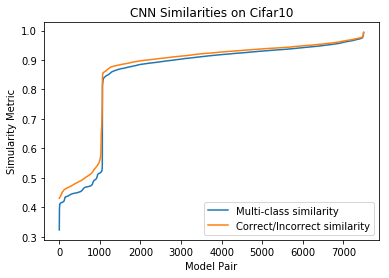

In [104]:
# Plot similarities!
plt.plot(sorted(mc_sims), label="Multi-class similarity")
plt.plot(sorted(corr_sims), label="Correct/Incorrect similarity")
plt.title("CNN Similarities on Cifar10")
plt.xlabel("Model Pair")
plt.ylabel("Simularity Metric")
plt.legend()
plt.show()

In [106]:
# Refine the analyis by bucketing using errors
gap = 0.05
valid_pairs = []
for i in range(len(predictions)):
    for j in range(len(predictions)):
        if np.abs(accs[i] - accs[j]) < gap:
            valid_pairs.append((i, j))

In [107]:
mc_sims = []
corr_sims = []
for (i, j) in tqdm.tqdm_notebook(valid_pairs):
    mc_sims.append(multiclass_simularity(i, j))
    corr_sims.append(correct_simularity(i, j))

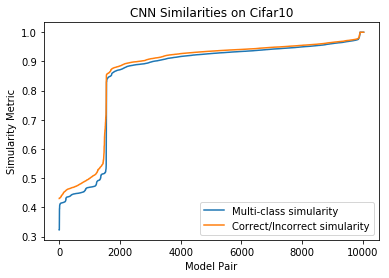

In [108]:
# Plot similarities!
plt.plot(sorted(mc_sims), label="Multi-class simularity")
plt.plot(sorted(corr_sims), label="Correct/Incorrect simularity")
plt.title("CNN Similarities on Cifar10")
plt.xlabel("Model Pair")
plt.ylabel("Simularity Metric")
plt.legend()
plt.show()